Rodrigo F. R da Silva

RA: 20.83984-7


Dados:  https://github.com/bchao1/Anime-Face-Dataset


## Lendo as Images

As imagens inicialmente zipadas, serao lidas na sessao do colab

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/cropped.zip","r") as zip_ref:
  zip_ref.extractall("targetdir")

In [8]:
# load all images in a directory
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# load all images in a directory
loaded_images = list()
images_path = '/content/targetdir/cropped/'
for filename in listdir(images_path):
    try:
      # load image
      img_data = Image.open(images_path+ filename)
      # store loaded image
      loaded_images.append(np.array(img_data.resize((32,32))))
    except:
      pass
loaded_images = np.asarray(loaded_images)

In [9]:
loaded_images.shape

(63569, 32, 32, 3)

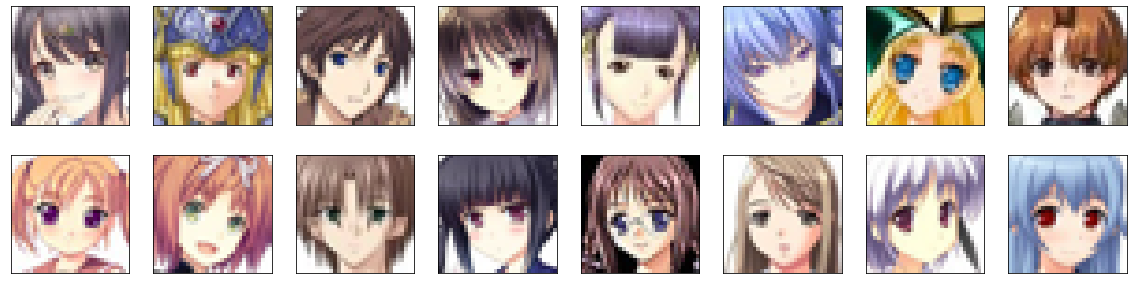

In [10]:
#Mostrando algumas imagens

f, pos = plt.subplots(2, 8, figsize=(20, 5))
for i in range(2):
  for j in range(8):
    index = i*8 + j
    pos[i,j].imshow(np.squeeze(loaded_images[index,:,:]))
    pos[i,j].axes.xaxis.set_visible(False)
    pos[i,j].axes.yaxis.set_visible(False)

plt.show()

# Normalizando as Images


In [11]:
loaded_images = (loaded_images - np.min(loaded_images)) / (np.max(loaded_images) - np.min(loaded_images))

In [12]:
# Importa classe de camadas e Keras backend
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow as tf
# Classe de camada do amsotrador
class Sampling(layers.Layer):
  # Método para inicializar classe
  def __init__(self):
  # Inicializa classe
    super(Sampling, self).__init__()

  # Método para realizar cálculos na camada do amsotrador
  def call(self, inputs):
    """Dados de entrada: 
    Vetor de médias: z_mean;
    Logaritmo do vetor de variâncias: z_log_var"""

    # Separa média e desvio padrão da entrada na forma de lista
    z_mean, z_log_var = inputs

    # Recupera dimensões dos tensores de média e desvio padrão
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]

    # Gera número aleatório com distribuição Gaussiana de média 0 e desvio padrão 1
    alfa = K.random_normal(shape=(batch, dim))

    # Retorna vetor de código amostrado
    return z_mean + tf.exp(0.5 * z_log_var) * alfa

#Codificador

In [13]:
# Importa camadas necessárias
from tensorflow.keras.models import Model,Sequential

shape = loaded_images.shape[1:4]
encoder_input = layers.Input(shape)

x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation=layers.LeakyReLU())(encoder_input)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation=layers.LeakyReLU())(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation=layers.LeakyReLU())(x)
x = layers.BatchNormalization()(x)

conv_shape = K.int_shape(x)

x = layers.Flatten()(x)

latent_dim = 2
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary()) 

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

#Decodificador

In [14]:
decoder_input  = layers.Input(shape=(latent_dim,))

decoder = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)


decoder_conv = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
# decoder_conv = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)

decoder_outputs = layers.Conv2D(3, kernel_size=1, strides=1, padding='same', activation='sigmoid')(decoder_conv)

decoder = Model(decoder_input, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3072      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 3)         99  

# Termo de Regularizacao KL da Funcao de Custo

In [15]:
# Termo de regularização KL
def KL_loss(z_mean, z_log_var):
  # calcula desvio padrão
  sigma = tf.exp(0.5 * z_log_var)
  
  # Calcula custo KL
  kl_loss = 0.5*(sigma**2 + z_mean**2 - z_log_var - 1.0)
  
  # Calcula média do resultado
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  
  return kl_loss

# Autoencoder

In [16]:
# define fator de regularização

beta = 1/(32*32)

# Camada de entrada
inputs = layers.Input(shape=(shape))

# Inclui codificador
z_mean, z_log_var, z = encoder(inputs)

# Incluir decodificador
decoder_output = decoder(z)

# Instância AEV
AEV = Model(inputs, decoder_output)

# Define termo de regularização KL 
loss = beta*KL_loss(z_mean, z_log_var)

# Adiciona termo de regularização KL omo função de custo adicional
AEV.add_loss(loss)

# Summario do AEV
AEV.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 80004       input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 32, 32, 3)    169283      encoder[0][2]                    
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 2)            0           encoder[0][1]                    
______________________________________________________________________________________________

In [17]:
# Define otimizador Adam
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilação do autoencoder
AEV.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [18]:
results = AEV.fit(x=loaded_images, 
                  y=loaded_images, 
                  epochs=100, 
                  batch_size=256,
                  shuffle=True)


Epoch 1/100
249/249 [==============================] - 130s 517ms/step - loss: 0.6096 - binary_accuracy: 0.0296
Epoch 2/100
249/249 [==============================] - 129s 520ms/step - loss: 0.5873 - binary_accuracy: 0.0293
Epoch 3/100
249/249 [==============================] - 130s 521ms/step - loss: 0.5861 - binary_accuracy: 0.0294
Epoch 4/100
249/249 [==============================] - 129s 520ms/step - loss: 0.5855 - binary_accuracy: 0.0294
Epoch 5/100
249/249 [==============================] - 129s 520ms/step - loss: 0.5854 - binary_accuracy: 0.0294
Epoch 6/100
249/249 [==============================] - 129s 520ms/step - loss: 0.5853 - binary_accuracy: 0.0294
Epoch 7/100
249/249 [==============================] - 130s 523ms/step - loss: 0.5850 - binary_accuracy: 0.0294
Epoch 8/100
249/249 [==============================] - 132s 530ms/step - loss: 0.5851 - binary_accuracy: 0.0294
Epoch 9/100
249/249 [==============================] - 132s 530ms/step - loss: 0.5846 - binary_accuracy:

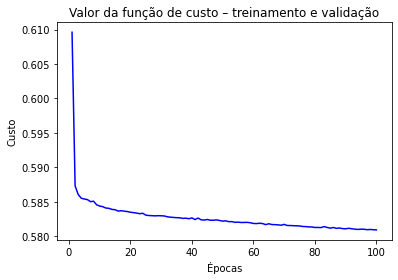

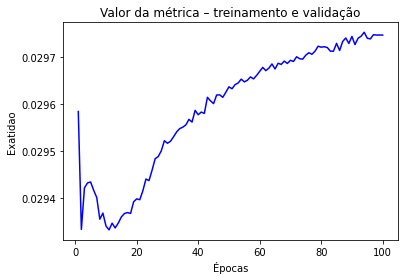

In [19]:
import matplotlib.pyplot as plt

def plot_train(history):
 history_dict = history.history
 # Salva custos, métricas em vetores 
 custo = history_dict['loss']
 acc = history_dict['binary_accuracy']
 # Cria vetor de épocas
 epocas = range(1, len(custo) + 1)
 # Gráfico dos valores de custo
 plt.plot(epocas, custo, 'b', label='Custo - treinamento')
 plt.title('Valor da função de custo – treinamento e validação')
 plt.xlabel('Épocas')
 plt.ylabel('Custo')
 plt.show()
 # Gráfico dos valores da métrica
 plt.plot(epocas, acc, 'b', label='exatidao- treinamento')
 plt.title('Valor da métrica – treinamento e validação')
 plt.xlabel('Épocas')
 plt.ylabel('Exatidao')
 plt.show()
plot_train(results)


# 1) Reconstrução de imagens do conjunto de dados. Reconstrua pelo menos 16 imagens e faça um gráfico das imagens reconstruídas junto com as imagens originais. Além disso, calcule o erro de reconstrução de cada imagem.

In [20]:
AEV.evaluate(loaded_images, loaded_images)

1987/1987 [==============================] - 53s 26ms/step - loss: 0.5811 - binary_accuracy: 0.0299


[0.5811281204223633, 0.029899287968873978]

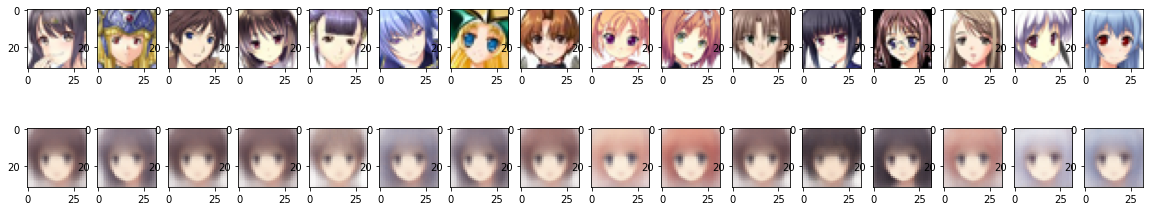

In [21]:
# Calcula dados reconstriuídos pelo AE
x_prev = 255*AEV.predict(loaded_images)
x_prev = x_prev.astype(int)
#Plot
f, pos = plt.subplots(2, 16, figsize=(20, 4))
for i in range(16):
  # plt.imshow(x_prev[0], interpolation='nearest')
  pos[0,i].imshow((loaded_images[i]*255).astype(int), cmap='gray')
  pos[1,i].imshow(x_prev[i], interpolation='nearest')
plt.show()

In [22]:
#erro e metrica para cada uma das images
for i in range(16):
  print(f"imagem numero {i}")
  AEV.evaluate(loaded_images[i:i+1], loaded_images[i:i+1])

imagem numero 0
1/1 [==============================] - 0s 28ms/step - loss: 0.6109 - binary_accuracy: 0.0195
imagem numero 1
1/1 [==============================] - 0s 16ms/step - loss: 0.6570 - binary_accuracy: 0.0033
imagem numero 2
1/1 [==============================] - 0s 15ms/step - loss: 0.6234 - binary_accuracy: 0.0326
imagem numero 3
1/1 [==============================] - 0s 16ms/step - loss: 0.6223 - binary_accuracy: 0.0221
imagem numero 4
1/1 [==============================] - 0s 15ms/step - loss: 0.5561 - binary_accuracy: 0.0667
imagem numero 5
1/1 [==============================] - 0s 16ms/step - loss: 0.6114 - binary_accuracy: 0.0156
imagem numero 6
1/1 [==============================] - 0s 15ms/step - loss: 0.6618 - binary_accuracy: 0.0091
imagem numero 7
1/1 [==============================] - 0s 15ms/step - loss: 0.6137 - binary_accuracy: 0.0277
imagem numero 8
1/1 [==============================] - 0s 26ms/step - loss: 0.5062 - binary_accuracy: 0.0635
imagem numero 9
1/1

In [23]:
AEV.evaluate(loaded_images[1:2], loaded_images[1:2])

1/1 [==============================] - 0s 15ms/step - loss: 0.6572 - binary_accuracy: 0.0033


[0.6572020053863525, 0.0032552082557231188]

# 2) Criação de imagens novas originais por meio da combinação da representação latente de duas imagens. Nessa etapa crie várias transições entre duas imagens do conjunto de dados, iniciando de uma delas até obter a outra. Faça isso para pelo menos 8 pares de imagens do conjunto de dados.

In [24]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=16):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=8):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :])

  
  plt.show()

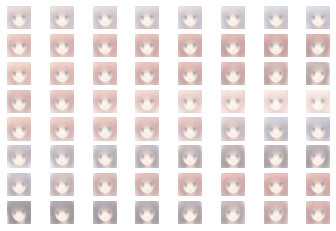

In [25]:
# generate points in latent space
n = 20
pts = generate_latent_points(2, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = decoder.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = np.vstack((results, X))
# plot the result
plot_generated(results, 8)

# 3) Criação de imagens novas originais a partir de vetores de ruídos. Crie pelo menos 16  imagens

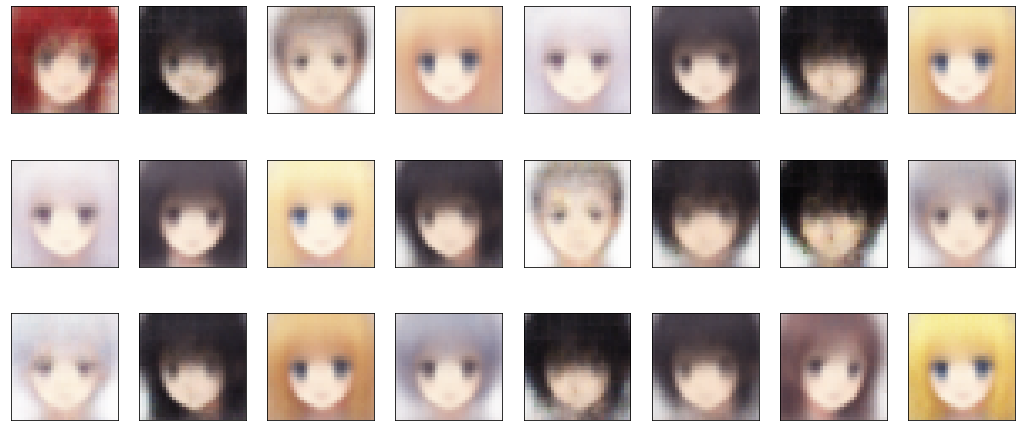

In [26]:
# representações latente geradas aleatóriamente
# Alterar sacle para selecionar dígitos diferentes
scale = 2.
z_rand = np.random.randn(24,latent_dim) + 2.0*scale*(np.random.randint(0, 2, (24, latent_dim)) - 0.5)
 
# Cria imagem a partir da representação latente 
reconst_images_vec = decoder.predict(z_rand)

# Mostra imagens construídas
f, pos = plt.subplots(3, 8, figsize=(18, 8))
for i in range(3):
  for j in range(8):
    index = i*8 + j
    pos[i,j].imshow(np.squeeze(reconst_images_vec[index]), cmap='gray')
    pos[i,j].axes.xaxis.set_visible(False)
    pos[i,j].axes.yaxis.set_visible(False)
plt.show()